지금까지 인공 신경망에 대해 배우고 텐서플로의 케라스 API를 사용해 직접 만들어보았다. 또한 1개 이상의 층을 추가해 심층 신경망을 구성하고 다양한 고급 옵티마이저를 적용하는 법도 알아보았다.

이전 사이킷런에서 제공하는 머신러닝 알고리즘은 좋은 성능을 내기 위해 매개변수를 조정하고 훈련하는 과정을 반복했다. 하지만 모델의 구조가 어느 정도 고정되어 있다고 느꼈을 것이다. 하지만 딥러닝은 모델의 구조를 직접 만든다는 느낌이 강하다. 

이번에는 케라스 API를 사용해 모델을 훈련하는데 필요한 다양한 도구들을 알아보자.

2절에서 fit() 메서드로 모델을 훈련하면 훈련 과정이 상세하게 출력되어 확인할 수 있었다. 이때 아래와 같은 문장이 출력된다.

* <tensorflow.python.keras.callbacks.History at 0x7fef38bfc080>

노트북의 코드 셀은 print() 명령을 사용하지 않아도 마지막 라인의 실행 결과를 자동으로 출력한다. 즉, 위 문장은 fit() 메서드의 실행 결과를 출력한 것이다.

**fit() 메서드는 History 클래스 객체를 반환한다.** History 객체는 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어있다. 이 값을 사용하면 그래프를 그려볼 수 있다.

먼저 이전 절에서 사용했던 데이터셋을 가져오고 훈련 세트와 검증 세트로 나누자.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)

4431872/4422102 [==============================] - 0s 0us/step


모델을 만들어 보자. 단, 이번에는 모델을 만드는 간단한 함수를 정의해보자.

In [2]:
def model_fn(a_layer = None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape = (28, 28)))
  model.add(keras.layers.Dense(100, activation = 'relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation = 'softmax'))
  return model

model_fn() 함수에 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가할 수 있다. 아래처럼 코드를 작성하면 이전 모델과 동일한 모델이 만들어진다.

In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


이전 절과 동일하게 모델을 훈련해보자. 단, fit() 메서드의 결과를 history 변수에 담아보자.


In [4]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 5, verbose = 0)

* **verbose 매개변수**는 훈련 과정 출력을 조절한다. 기본값은 1로 에포크마다 진행 막대와 함께 손실 등의 지표가 출력된다. 값이 2라면 진행 막대를 빼고 출력한다. 값을 0으로 지정하면 훈련 과정을 나타내지 않는다.

**history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어있다.** 이 딕셔너리에 어떤 값이 들어 있는지 확인해보자.

In [5]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [6]:
print(history.history['loss'])
print(history.history['accuracy'])

[0.537104606628418, 0.39454910159111023, 0.35468095541000366, 0.3329482972621918, 0.3192276060581207]
[0.8113750219345093, 0.8575208187103271, 0.8709166646003723, 0.8798333406448364, 0.8845000267028809]


**손실과 정확도가 포함되어 있다.** 케라스는 기본적으로 에포크마다 손실을 계산한다. 정확도는 compile() 메서드에서 metrics 매개변수에 추가했기 때문에 history 속성에 포함된다.

맷플롯립을 사용해 손실 그래프를 그려보자.

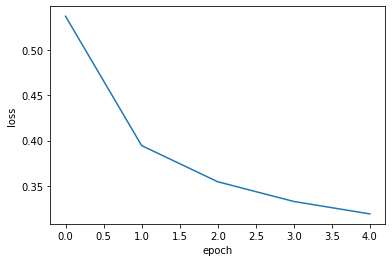

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

이번에는 정확도를 출력해보자.

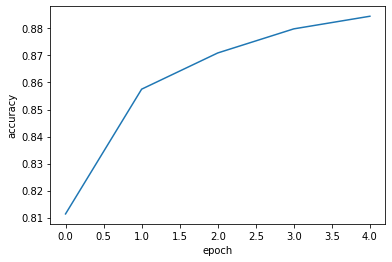

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크마다 손실이 감소하고 정확도가 향상된다. 

이번에는 에포크 횟수를 20으로 늘려서 모델을 훈련하고 손실 그래프를 그려보자.

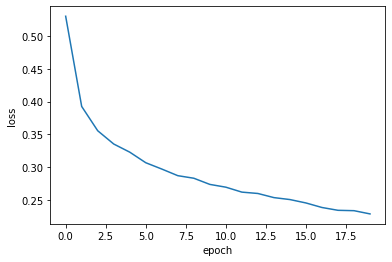

In [9]:
model = model_fn()
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

예상대로 손실이 잘 감소한다. 하지만 너무 많은 에포크를 진행하면 과대적합의 문제가 발생한다. 즉, 우리는 에포크에 따른 과대적합과 과소적합을 고려해야한다. 이를 위해 훈련 세트에 대한 점수뿐만 아니라 검증 세트에 대한 점수도 필요하다. 

* **인공 신경망 모델 최적화하는 대상은 정확도가 아니라 손실 함수이다.** 종종 손실 감소에 비례해 정확도가 높아지지 않는 경우도 있다. 따라서 모델이 잘 훈련되었는지 판단하려면 정확도보다 손실 함수의 값을 확인하는 것이 더 좋다.

에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달할 수 있다. **validation_data 매개변수**에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달하면 된다.

In [10]:
model = model_fn()
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target))

반환된 history.history 딕셔너리에 어떤 값이 들어있는지 확인해보자.

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


'val_loss'와 'val_accuracy'가 추가되었다. 훈련 손실과 검증 손실을 그래프로 그려보자.

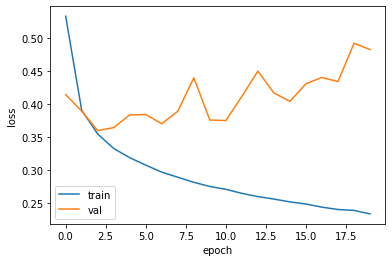

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 손실이 감소하다가 다섯 번째 에포크 만에 상승하기 시작한다. 훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어진다. 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.

먼저 옵티마이저를 조정해 과대적합을 완화해보자. Adam을 사용해 훈련 손실과 검증 손실을 다시 그려보자.

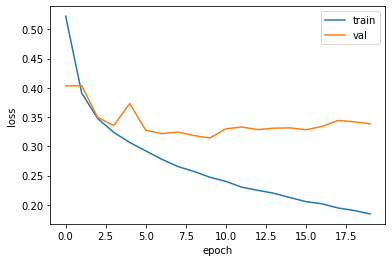

In [13]:
model = model_fn()
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대 적합이 훨씬 줄었다. 검증 손실 그래프에 여전히 요동이 남아 있지만 열 번째 에포크까지 전반적인 감소 추세가 이어진다. 즉, Adam 옵티마이저가 이 데이터셋에 잘 맞는다는 것을 알 수 있다. 더 나은 곡선을 얻으려면 학습률을 조정해서 시도해 볼 수도 있다.

학습률을 높여서 손실 그래프를 그려보자.

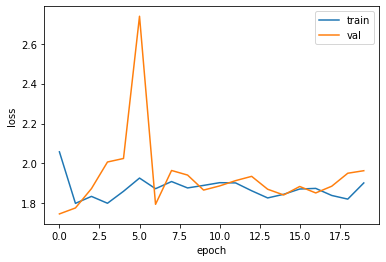

In [14]:
adam = keras.optimizers.Adam(learning_rate = 0.1)
model = model_fn()
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

학습률을 높이니 훨씬 안좋은 결과를 가져왔다. 학습률을 낮춰보자.

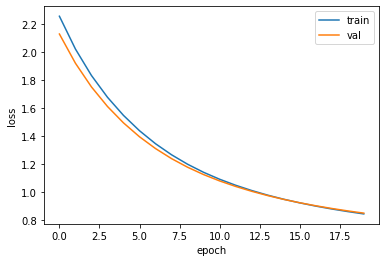

In [15]:
adam = keras.optimizers.Adam(learning_rate = 0.000001)
model = model_fn()
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

학습률을 낮추니 과대적합을 잘 해결한 듯 하다. 이제 이외에 신경망에서 사용하는 대표적인 규제 방법을 알아보자.

**'드롭아웃(dropout)'**은 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(즉 뉴런의 출력을 0으로 만들어) 과대적합을 막는다. 뉴런은 랜덤하게 드롭아웃되고 얼마나 많은 뉴런을 드롭할지는 우리가 정해야 할 또 다른 하이퍼파라미터이다.

**이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 주의를 기울여야하므로 과대적합을 막을 수 있다.** 매번 랜덤하게 뉴런이 꺼지므로 여러개의 신경망을 학습시키는 효과를 볼 수 있다. 즉 신경망을 앙상블한다고 생각할 수 있다

* 앙상블 학습은 더 좋은 예측 결과를 만들기 위해 여러 개의 모델을 훈련하는 머신러닝 알고리즘이다.

케라스는 keras.layers 패키지 아래에 **Dropout 클래스**를 제공한다. 30% 정도를 드롭아웃해보자.

In [16]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


드롭아웃 층은 훈련되는 모델 파라미너가 없으며 입력과 출력의 크기가 같다. 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않는다.

**훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야한다.** 훈련된 모든 뉴런을 사용해야 올바른 예측을 수행할 수 있기 때문이다. 텐서플로와 케라스는 모델을 평가와 예측할 때는 자동으로 드롭아웃을 적용하지 않는다. 이전과 같이 손실 그래프를 그려보자.

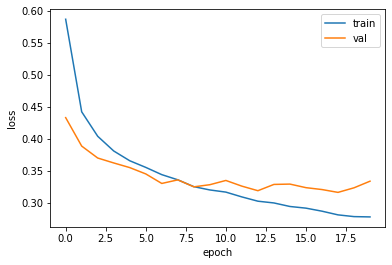

In [17]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 줄은 것을 확인할 수 있다. 열 번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지되고 있다. 따라서 과대적합 되지 않은 모델을 얻기 위해 에포크 횟수를 10으로 하고 다시 훈련해보자.

In [18]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 10, verbose = 0, validation_data = (val_scaled, val_target))

에포크 횟수를 10으로 지정하고 모델을 훈련했다. 이 모델을 나중에 쓰기 위해 저장할 방법은 없을까? 

케라스에서는 훈련된 모델의 파라미터를 저장하기 위해 **save_weights() 메서드**를 제공한다. 기본적으로 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'이면 HDF5 포맷으로 저장한다.

In [19]:
model.save_weights('model-weights.h5')

모델 구조와 모델 파라미터를 함게 저장하려면 save() 메서드를 사용하면된다. 기본적으로 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [20]:
model.save('model-whole.h5')

두 파일이 잘 만들어 졌는지 확인해보자.

In [21]:
!ls -al *.h5

-rw-r--r-- 1 root root 332480 Oct  1 14:07 model-weights.h5
-rw-r--r-- 1 root root 981736 Oct  1 14:07 model-whole.h5


훈련하지 않은 모델을 만들고 model-weights.h5 파일에서 훈련된 모델 파라미터를 일어서 사용해보자.

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

훈련하지 않은 새로운 모델을 만들고 이전에 저장했던 모델 파라미터를 적재했다. 이때 사용하는 메서드는 **load_weight() 메서드**이다.

* load_weights() 메서드를 사용하려면 save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야한다.

이 모델의 검증 정확도를 확인해보자. 패션 MNIST 데이터셋은 다중 분류 문제이므로 케라스의 **predict() 메서드**는 샘플마다 10개의 클래스에 대한 확률을 반환한다. 패션 MNIST 데이터셋에서 덜어낸 검증 세트의 샘플은 12,000개이므로 predict() 메서드는 (12000, 10) 크기의 배열을 반환한다. 10개의 확률 중에 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산해보자.

* 모델 파라미터를 읽은 후 evaluate() 메서드를 사용하여 정확도를 출력할 수 있지만, **evaluate() 메서드는 손실을 계산하기 위해 먼저 compile() 메서드를 실행해야한다**. 여기서는 새로운 데이터에 대해 정확도만 계산하면 되는 상황이라고 가정하자.

In [23]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis = -1)
print(np.mean(val_labels == val_target))

0.881


argmax() 함수의 axis = -1은 배열의 마지막 차원을 따라 최댓값을 고른다. 즉, axis = 1과 동일한 코드이다.

* axis = 0이면 행을 따라 열의 최댓값 인덱스를 선택하고 axis = 1이면 열을 따라 행의 최댓값 인덱스를 선택한다.

이번에는 모델 전체를 파일에서 읽고 검증 세트의 정확도를 출력해보자. 케라스의 **load_model() 함수**를 사용하면 된다.

In [24]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3246 - accuracy: 0.8810


[0.32456499338150024, 0.8809999823570251]

* load_model() 함수는 모델 파라미터뿐만 아니라 모델 구조와 옵티마이저 상태까지 모두 복원하여 evaluate() 메서드를 사용할 수 있다.

지금까지 20번의 에포크 동안 모델을 훈련하여 검증 점수가 상승하는 지점을 확인했다. 그리고 모델이 과대적합 되지 않는 에포크만큼 다시 훈련했다. 모델을 두 번씩 훈련하지 않고 한 번에 끝낼 수는 없을까?

**'콜백(callback)'**은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이다. fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다. 우리는 **ModelCheckpoint 콜백**을 사용할 것이다. ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다. **save_best_only 매개변수**를 True로 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다. 저장될 파일 이름을 'best-model.h5'로 지정하여 콜백을 적용해보자.

In [25]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only = True)
model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb])

이 모델을 load_mo최상의 검증 점수를 낸 모델을 load_model() 함수로 다시 읽어서 예측을 수행해보자.

In [26]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3127 - accuracy: 0.8899


[0.3126643896102905, 0.8899166584014893]

ModelCheckpoint 콜백이 가장 낮은 검증 점수의 모델을 자동으로 저장해 준다. 하지만 여전히 20번의 에포크 동안 훈련을 한다.

검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없다. 이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있다. 이렇게 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 '조기 종료(early stopping)'라고 부른다.

조기 종료는 훈련 에포크 횟수를 제한하는 역할이지만 모델이 과대적합되는 것을 막아주기 때문에 규제 방법 중 하나라고 생각할 수 있다.

케라스에는 조기 종료를 위해 **EarlyStopping 콜백**을 제공한다. 이 콜백의 **patience 매개변수**는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정한다. 예를 들어 patience를 2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다. 또한 **restore_best_weights 매개변수**를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.

EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다. 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

In [27]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

훈련을 마치고 몇 번째 에포크에서 훈련이 중지되었는지 early_stopping_cb 객체의 **stopped_epoch 속성**에서 확인할 수 있다.

In [28]:
print(early_stopping_cb.stopped_epoch)

9


에포크 횟수는 0부터 시작하므로 열 번째 에포크에서 훈련이 중지되었음을 의미한다. patience를 2로 지정했으니 최상의 모델은 여덟 번째 에포크일 것이다.

훈련 손실과 검증 손실을 출력해보자.

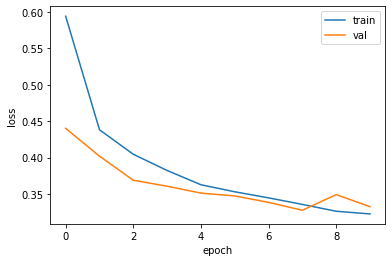

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

여덟 번째 에포크에서 가장 낮은 손실을 기록했고 열 번째 에포크에서 훈련이 중지되었다. 조기 종료 기법을 사용하면 에포크 횟수를 크게 지정해도 괜찮다. 컴퓨터 자원과 시간을 아낄 수 있고 ModelCheckpoint 콜백과 함께 사용하면 최상의 모델을 자동으로 저장하므로 편리하다.

마지막으로 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해보자.

In [30]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3277 - accuracy: 0.8823


[0.32772162556648254, 0.8823333382606506]

# 정리

핵심 포인트
* 드롭아웃: **은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법**이다. 드롭아웃은 훈련 중에 적용되며 평가나 예측에서는 적용하지 않는다.
* 콜백: **케라스 모델을 훈련하는 도중 어떤 작업을 수행할 수 있도록 도와주는 도구**이다. 대표적으로 최상의 모델을 자동으로 저장해 주거나 검증 점수가 더 이상 향상되지 않으면 일찍 종료하는 클래스 들이 있다.
* 조기 종료: **검증 점수가 더 이상 감소하지 않고 상승하여 과대적합이 일어나면 훈련을 계속 진행하지 않고 멈추는 기법**이다. 계산 비용과 시간을 절약할 수 있다.

핵심 패키지와 함수

TensorFlow
* Dropout: **드롭아웃 층**이다. 첫 번째 매개변수로 **드롭아웃 할 비율(r)**을 지정한다. 드롭아웃 하지 않는 뉴런의 출력은 1/(1-r)만큼 증가시켜 출력의 총합이 같도록 만든다.
* save_weights(): **모든 층의 가중치와 절편을 파일에 저장한다.** 첫 번째 매개변수에 저장할 파일을 지정한다.
* load_weigths(): **모든 층의 가중치와 절편을 파일에 읽는다.** 첫 번재 매개변수에 읽을 파일을 지정한다.
* save(): **모델 구조와 모든 가중치와 절편을 파일에 저장한다.** 첫 번재 매개변수에 저장할 파일을 지정한다.
* load_model(): **model_save() 로 저장된 모델을 로드한다.** 첫 번째 매개변수에 읽을 파일을 지정한다.
* ModelCheckpoint: **케라스 모델과 가중치를 일정 간격으로 저장한다.** 첫 번째 매개변수에 저장할 파일을 지정한다. **monitor 매개변수**는 모니터링할 지표를 저장한다. 기본값은 'val_loss'로 검증 손실을 관찰한다. **save_weights_only 매개변수**의 기본값은 False로 전체 모델을 저장한다. True로 지정하면 모델의 가중치와 절편만 저장한다. **save_best_only 매개변수**를 True로 지정하면 가장 낮은 검증 점수를 만드는 모델을 저장한다.
* Earlystopping: **관심 지표가 더이상 향상하지 않으면 훈련을 중지한다.** **monitor 매개변수**는 모니터링할 지표를 지정한다. 기본값은 'val_loss'로 검증 손실을 관찰한다. **patience 매개변수**에 모델이 더이상 향상되지 않고 지속할 수 있는 최대 에포크 횟수를 지정한다. **restore_best_weights 매개변수**에 최상의 모델 가중치를 복원할지 지정한다. 기본값은 False이다.

Numpy
* argmax: **배열에서 축을 따라 최댓값의 인덱스를 반환한다.** axis 매개변수에서 어떤 축을 따라 최댓값을 찾을지 지정한다. 기본값은 None으로 전체 배열에서 최댓값을 찾는다.
